# Recommender Systems - Bag of Words

The following script attempts to predict whether a user will be interested in a scientific article or not. 
To do this the CiteULike dataset is used. the dataset contains the previous interactions between users and other scientific artiles. Using embeddings for users and items a prediction can be done. 
The following BoW model uses the article titles.

The following code borrows heavily from the following websites

https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/3_Recurrent/3.1-Sequencial-Data.ipynb

https://github.com/pytorch/text 

http://anie.me/On-Torchtext/

https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84?fbclid=IwAR0cV9dnv4P5snK_SONbKUJ7lP4dlw1lAifju2OwS-gJ6aaKgarXuIDatuk

https://towardsdatascience.com/use-torchtext-to-load-nlp-datasets-part-i-5da6f1c89d84?fbclid=IwAR0EyyeiCQMUtThSBMqhmI1ObQiuExKmbKM1g_kk7MfykENDVY4BEzB3v-4


In [1]:
#!pip install torchtext
#!pip install torch

In [2]:
#### Packages ####
import pandas as pd
import numpy as np
import spacy
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from torch.autograd import Variable
from torch import nn
from random import shuffle
from torch.nn import Linear
from torch.nn.functional import softmax, relu
from torchtext.data import Dataset, BucketIterator, Field, TabularDataset, Iterator
from torchtext.vocab import Vocab

In [3]:
#### Function to return numpy array ####
def get_numpy(x):
    return x.data.numpy()

In [4]:
#### Read datasets ####
CiteULike_data = pd.read_csv("raw-data.csv")

#### Loading small dataset for speed ####
User_info = pd.read_csv("user-info-small.csv")

#### Create function for index moving ####
def zero_indexing(nparr):
    # Function moves index of users etc 1 down (python is 0-indexed)
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr]), uniq

#### Move index, shuffle ####
User_info["user.id"], uniq = zero_indexing(User_info["user.id"].values)
User_info = User_info.sample(frac=1)

#### Replace doc.id with title of article ####
User_info["doc.id"] = [CiteULike_data.iloc[int(idx),1] for idx in User_info["doc.id"]]


#### Split train, validation and test in respectively 70%,20% and 10% of the data size ####
n = len(User_info)
trn_len = int(n*0.7)
val_len = int(n*0.2)
test_len = n-trn_len-val_len

train = User_info[:trn_len]
val = User_info[trn_len:-test_len]
test = User_info[trn_len:-val_len]

In [5]:
#### Defining unique coloumns and userId and removing the header #### 
uniq_items = np.unique(CiteULike_data["doc.id"])[:-1]
uniq_users = np.unique(train["user.id"])[:-1]
items = set((x[0],x[1]) for x in train[["user.id","doc.id"]].values)

#### Find pairs in the data. Create negative samples from the missing obsevation (no interaction) ####
pairs = []
i = 0
while(i < len(train)):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0)]
        items.add((user,item))

User_info_Negatives = np.vstack((train, pairs))

#### Create datasets and save these for later
train = pd.DataFrame(data = User_info_Negatives,columns = ["user.id","doc.id", "rating"])
test.to_csv('test.csv', header = False, index = False)

#### Cleanup of memory
del User_info_Negatives, items, uniq_items, uniq_users, pairs, User_info, test

for i, idx in enumerate(train["doc.id"][trn_len:]):
    train["doc.id"].loc[trn_len+i] = CiteULike_data.iloc[int(idx),1]

train = train.sample(frac = 1)

train.to_csv('train.csv', header = False, index = False)


In [6]:
#### Defining unique coloumns and userId and removing the header #### 
uniq_items = np.unique(CiteULike_data["doc.id"])[:-1]
uniq_users = np.unique(val["user.id"])[:-1]
items = set((x[0],x[1]) for x in val[["user.id","doc.id"]].values)

#### Find pairs in the data. Create negative samples from the missing obsevation (no interaction) ####
pairs = []
i = 0
while(i < len(val)):
    
    item = np.random.choice(uniq_items, size = 1)[0]
    user = np.random.choice(uniq_users, size = 1)[0]
    if (user,item) not in items:
        i += 1
        pairs += [(user,item,0)]
        items.add((user,item))

User_info_Negatives = np.vstack((val, pairs))

#### Create datasets and save these for later
val = pd.DataFrame(data = User_info_Negatives,columns = ["user.id","doc.id", "rating"])

#### Cleanup of memory
del User_info_Negatives, items, uniq_items, uniq_users, pairs

for i, idx in enumerate(val["doc.id"][val_len:]):
    val["doc.id"].loc[val_len+i] = CiteULike_data.iloc[int(idx),1]

val = val.sample(frac = 1)

val.to_csv('val.csv', header = False, index = False)

In [7]:
#### Printing example of dataset ####
CiteULike_data.head()

,doc.id,title,citeulike.id,raw.title,raw.abstract
0,1,the metabolic world of escherichia coli is not...,42,The metabolic world of Escherichia coli is not...,To elucidate the organizational and evolutiona...
1,2,reverse engineering of biological complexity,43,Reverse Engineering of Biological Complexity,Advanced technologies and biology have extreme...
2,3,exploring complex networks,44,Exploring complex networks,"The study of networks pervades all of science,..."
3,4,comparative assessment of largescale data sets...,46,Comparative assessment of large-scale data set...,Comprehensive protein protein interaction maps...
4,5,navigation in a small world,47,Navigation in a small world,The small-world phenomenon — the principle tha...


In [8]:
#### Load spaCy to tokenize text ####
spacy_en = spacy.load('en')

#### Define a tokenizer function ####
def tokenizer(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]




TEXT = Field(sequential = True, lower = True)
LABEL = Field(sequential = False, use_vocab = False)
ID = Field(sequential = False, use_vocab = False)

train, val, test = TabularDataset.splits(
        path ='', train = 'train.csv',
        validation = 'val.csv', test ='test.csv', format = 'csv',
        fields = [('ID', ID), ('Text', TEXT), ('Label', LABEL)])


print('Content of first training sample:')
pprint(vars(train[0]))

#### Create vocabulary using pretrained embeddings from GloVe ####
TEXT.build_vocab(train, vectors = "glove.6B.100d")
LABEL.build_vocab(train)
ID.build_vocab(train)

Content of first training sample:
{'ID': '13',
 'Label': '0',
 'Text': ['ll',
          'a',
          'simple',
          'tool',
          'for',
          'discovering',
          'the',
          'hidden',
          'significance',
          'in',
          'microarray',
          'expression',
          'data']}


In [9]:
#### TEXT and LABEL ####
print('Text fields:')
print(" vocabulary's embedding dimension:", TEXT.vocab.vectors.size())
print(' no. times the "biology" appear in the dataset:', TEXT.vocab.freqs['biology'])

print('\nLabel fields:')
print(" list of vocabulary (int-to-str):", LABEL.vocab.itos)
print(" list of vocabulary (str-to-int):", dict(LABEL.vocab.stoi))


Text fields:
 vocabulary's embedding dimension: torch.Size([5088, 100])
 no. times the "biology" appear in the dataset: 38

Label fields:
 list of vocabulary (int-to-str): ['<unk>', '0', '1']
 list of vocabulary (str-to-int): {'<unk>': 0, '0': 1, '1': 2}


In [10]:
#### Define batchsizes and create dataset splits ####
batch_size = (30, 30, 30)

#### Remebering to sort the text for speed ####
train_iter, val_iter, test_iter = BucketIterator.splits(
    (train, val, test), batch_sizes = batch_size, sort_key = lambda x: len(x.Text))

In [11]:
#### Batch Information ####
batch = next(iter(train_iter))
print("Dimension of batch's text:")
print(batch.Text.size())
print("\nFirst sequence in text:")
print(batch.Text[:,0])
print("\nCorrect label index:")
print(batch.Label[0])
print("\nThe actual label:")
print( LABEL.vocab.itos[get_numpy(batch.Label[0])])


Dimension of batch's text:
torch.Size([14, 30])

First sequence in text:
tensor([  178,   184,    59,   106,  4545,  1617,     3,   491,   428,
         2733,  4676,     1,     1,     1])

Correct label index:
tensor(1)

The actual label:
0


In [12]:
#### Embedding sizes ####
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

#### The BoW Model ####
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        # Linear layers
        self.l_1 = Linear(in_features = embedding_dim,
                           out_features = embedding_dim,
                           bias = True)
        
        self.l_2 = Linear(in_features = embedding_dim,
                           out_features = 30,
                           bias = True)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(p = 0.5)
        self.dropout2 = nn.Dropout(p = 0.5)
        
        # Output layer
        self.l_out = Linear(in_features = 30,
                            out_features = num_classes,
                            bias = False)
        
    def forward(self, x):
        # Make space
        out = {}
        # Get embeddings
        x = self.embeddings(x)
        
        # Find the mean of embeddings (BoW -trick)
        out['bow'] = x = torch.mean(x, dim=0)
        
        # Feed into NN
        out['l1_activations'] = x = self.dropout1(relu(self.l_1(x)))
        out['l2_activations'] = x = self.dropout2(relu(self.l_2(x)))

        # Softmax
        out['out'] = softmax(self.l_out(x), dim = 1)
        return out

net = Net()

#### Information on the model ####
print(net)

Net(
  (embeddings): Embedding(5088, 100)
  (l_1): Linear(in_features=100, out_features=100, bias=True)
  (l_2): Linear(in_features=100, out_features=30, bias=True)
  (dropout1): Dropout(p=0.5)
  (dropout2): Dropout(p=0.5)
  (l_out): Linear(in_features=30, out_features=3, bias=False)
)


In [13]:
#### Defining Loss function, optimizer and performance estimation ####
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay = 1e-5)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

Iteration: 0 | training loss: 1.11 training accs: 0.10 | validation loss: 1.10 valitation accs: 0.14
Iteration: 500 | training loss: 1.04 training accs: 0.48 | validation loss: 0.96 valitation accs: 0.50
Iteration: 1000 | training loss: 0.97 training accs: 0.50 | validation loss: 0.96 valitation accs: 0.49
Iteration: 1500 | training loss: 0.97 training accs: 0.50 | validation loss: 0.96 valitation accs: 0.49
Iteration: 2000 | training loss: 0.96 training accs: 0.50 | validation loss: 0.96 valitation accs: 0.50
Iteration: 2500 | training loss: 0.96 training accs: 0.51 | validation loss: 0.96 valitation accs: 0.50
Iteration: 3000 | training loss: 0.96 training accs: 0.51 | validation loss: 0.96 valitation accs: 0.49
Iteration: 3500 | training loss: 0.96 training accs: 0.50 | validation loss: 0.96 valitation accs: 0.49
Iteration: 4000 | training loss: 0.96 training accs: 0.51 | validation loss: 0.96 valitation accs: 0.48
Iteration: 4500 | training loss: 0.96 training accs: 0.51 | validati

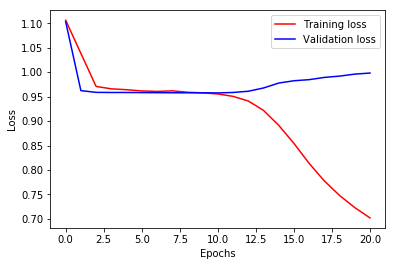

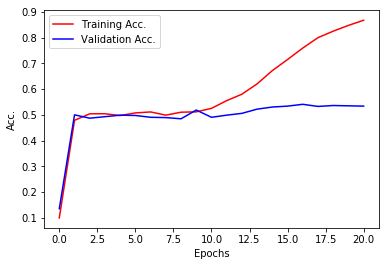

In [14]:
#### Defining maximum number of iterations and when to print ####
max_iter = 10000
eval_every = 500
log_every = 500

# Make space
train_loss = [] 
train_accs = []

accs_train = []
losses_train = []
accs_val = []
losses_val = []

#### All Systems Go! ####
net.train()
for i, batch in enumerate(train_iter):
    
    if i % log_every == 0:
        net.eval()
        val_losses = 0
        val_accs = 0
        val_lengths = 0
        
        for val_batch in val_iter:
            output = net(val_batch.Text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
            val_losses += criterion(output['out'], val_batch.Label) * val_batch.batch_size
            #print("output")
            #print(output["out"])
            #print("val_batch.Label")
            #print(val_batch.Label)
            #print("val_batch.batch_size")
            #print(val_batch.batch_size)
            val_accs += accuracy(output['out'], val_batch.Label) * val_batch.batch_size
           
            val_lengths += val_batch.batch_size
            
        # divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        net.train()
    
    output = net(batch.Text)
    batch_loss = criterion(output['out'], batch.Label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output['out'], batch.Label)))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    if i % log_every == 0:  
        accs_train += [np.mean(train_accs)]
        losses_train += [np.mean(train_loss)] 
        accs_val += [get_numpy(val_accs)]
        losses_val += [get_numpy(val_losses)]
        
        print("Iteration: {} | training loss: {:.2f} training accs: {:.2f} | validation loss: {:.2f} valitation accs: {:.2f}".format(i, np.mean(train_loss), np.mean(train_accs), get_numpy(val_losses), get_numpy(val_accs)))
        # Reset
        train_loss, train_accs = [], []
        
    if max_iter < i:
        #### Plots ####
        plt.figure()   
        plt.plot(losses_train, 'r',losses_val,'b')
        plt.legend(['Training loss','Validation loss'])
        plt.xlabel('Epochs'), plt.ylabel('Loss')
        
        plt.figure()   
        plt.plot(accs_train, 'r',accs_val,'b')
        plt.legend(['Training Acc.','Validation Acc.'])
        plt.xlabel('Epochs'), plt.ylabel('Acc.')
        break